# Evaluation of bandit algorithm

Figures 5 & 6 in the paper.

In [1]:
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scipy.stats import entropy

from impatient_bandits import (
    BayesianBandit,
    ProgressiveBelief,
    DelayedBelief,
    OracleBelief,
    DayTwoBelief,
    EmpiricalDistribution,
    Environment,
    StickinessHelper,
)

In [2]:
# Training set.
with open("data/synthetic-data-train.pkl", "rb") as f:
    raw = pickle.load(f)

data_train = {k: v.astype(float) for k, v in raw.items()}
helper = StickinessHelper.from_data(data_train)

In [3]:
def bandit_trial(
    env,
    beliefs,
    horizon,
    n_actions,
):
    agent = BayesianBandit(beliefs)
    regrets = list()
    entropies = list()
    r_optimal = max(env.dists[uri].mean_sum for uri in env.dists)
    for t in range(horizon):
        # Pick a number of actions.
        actions = agent.act(n_actions)
        for i, action in enumerate(actions):
            # `step` returns a-vector of activities and number of users.
            trace = env.step(action, t)
            # Update the bandit's reward models based on observed outcome
            agent.update(action, trace)
        agent.step()
        true_rewards = np.array([env.dists[action].mean_sum for action in actions])
        regrets.append(np.mean(r_optimal - true_rewards))
        # Compute entropy
        _, counts = np.unique(actions, return_counts=True)
        probs = counts / counts.sum()
        entropies.append(entropy(probs))
    return np.array(regrets), np.array(entropies)

## 200 shows

In [4]:
# Simulation parameters
horizon = 180
n_shows = 200
n_actions = (10, 50, 200)
n_trials = 10

rng = np.random.default_rng(seed=1)

# Evaluation set.
with open("data/synthetic-data-eval.pkl", "rb") as f:
    raw = pickle.load(f)

data_eval = {k: v.astype(float) for k, v in itertools.islice(raw.items(), n_shows)}

dists = {
    uri: EmpiricalDistribution(traces, seed=rng) for uri, traces in data_eval.items()
}
env = Environment(dists)

In [5]:
%%time

belief_classes = (
    ("Progressive", ProgressiveBelief),
    ("Delayed", DelayedBelief),
    ("Day-two proxy", DayTwoBelief),
    ("Oracle", OracleBelief),
)

reg = collections.defaultdict(dict)
ent = collections.defaultdict(dict)

for n in n_actions:
    print(f"# actions: {n}")
    for name, cls in belief_classes:
        reg[n][name] = np.zeros((n_trials, horizon))
        ent[n][name] = np.zeros((n_trials, horizon))
        for k in range(n_trials):
            print(".", end="", flush=True)
            env.reset()
            # Initialise stickiness beliefs per show
            beliefs = dict()
            for idx, uri in enumerate(data_eval):
                beliefs[uri] = cls(
                    prior_mvec=helper.prior_mvec,
                    prior_cmat=helper.prior_cmat,
                    noise_cmat=helper.noise_cmat,
                    cov_estimator="fixed",
                    seed=rng,
                )
            # Evaluate algorithm
            reg_, ent_ = bandit_trial(
                env,
                beliefs,
                horizon,
                n,
            )
            reg[n][name][k] = reg_
            ent[n][name][k] = ent_
        print()

# actions: 10
..........
..........
..........
..........
# actions: 50
..........
..........
..........
..........
# actions: 200
.

/Users/lucasm/Documents/impatient-bandits/lib/impatient_bandits/data.py:51: UserWarning: sampled more user traces than available
  warnings.warn("sampled more user traces than available")


.........
..........
..........
..........
CPU times: user 1h 19min 46s, sys: 4min 28s, total: 1h 24min 15s
Wall time: 16min


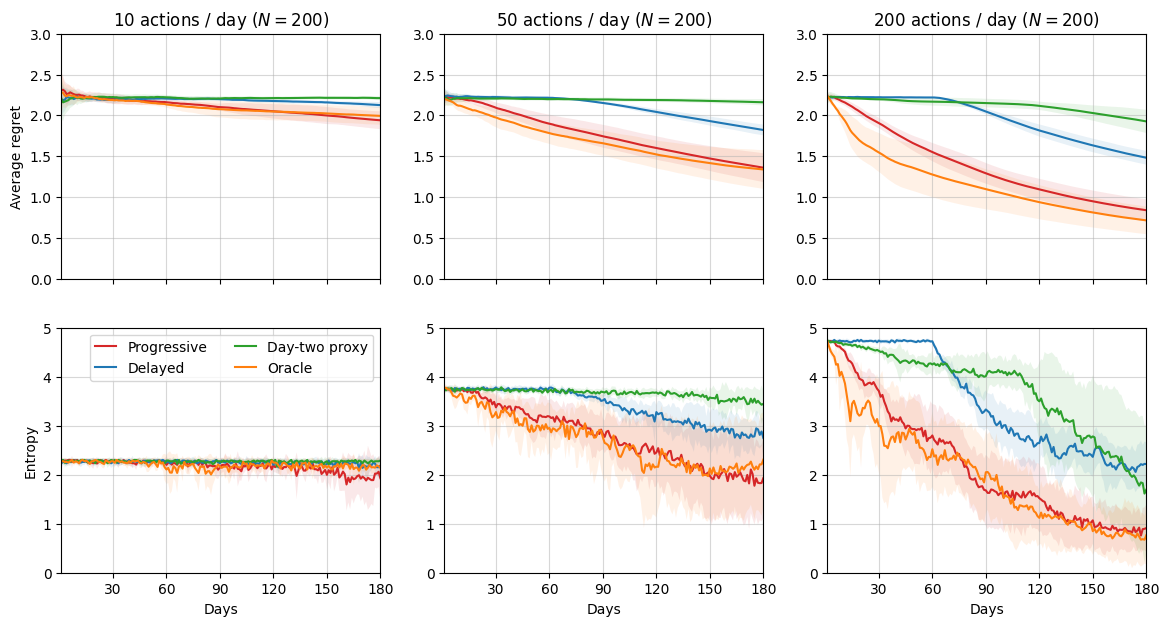

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(14, 7))
xs = np.arange(1, horizon + 1)

color = {
    "Progressive": plt.cm.tab10(3),
    "Delayed": plt.cm.tab10(0),
    "Day-two proxy": plt.cm.tab10(2),
    "Oracle": plt.cm.tab10(1),
}
linestyle = {
    "Progressive": "-",
    "Delayed": "--",
    "Day-two proxy": "--",
    "Oracle": "--",
}

for col, n in enumerate(n_actions):
    axs[0, col].set_title(f"{n} actions / day ($N = {n_shows}$)")
    for name, regrets in reg[n].items():
        # Average regret.
        areg = np.cumsum(regrets, axis=1) / xs
        mean = np.mean(areg, axis=0)
        std = np.std(areg, axis=0)
        axs[0, col].plot(xs, mean, ls="-", color=color[name], label=name)
        axs[0, col].fill_between(
            xs, mean - std, mean + std, facecolor=color[name], alpha=0.1
        )
        axs[0, col].set_ylim(ymin=0, ymax=3)
        axs[0, col].grid(alpha=0.5)
    for name, entropies in ent[n].items():
        mean = np.mean(entropies, axis=0)
        std = np.std(entropies, axis=0)
        axs[1, col].plot(xs, mean, ls="-", color=color[name], label=name)
        axs[1, col].fill_between(
            xs, mean - std, mean + std, facecolor=color[name], alpha=0.1
        )
        axs[1, col].set_ylim(ymin=0, ymax=5)
        axs[1, col].set_xlabel("Days")
        axs[1, col].grid(alpha=0.5)

axs[1, 0].legend(frameon=True, ncol=2, handlelength=1.5)
axs[0, 2].set_xlim(xmin=1, xmax=180)
axs[0, 2].set_xticks(np.arange(30, 181, step=30))
axs[0, 0].set_ylabel("Average regret")
axs[1, 0].set_ylabel("Entropy");

## 50 shows

In [7]:
# Simulation parameters
horizon = 180
n_shows = 50
n_actions = (10, 50, 200)
n_trials = 10

rng = np.random.default_rng(seed=1)

# Evaluation set.
with open("data/synthetic-data-eval.pkl", "rb") as f:
    raw = pickle.load(f)

data_eval = {k: v.astype(float) for k, v in itertools.islice(raw.items(), n_shows)}

dists = {
    uri: EmpiricalDistribution(traces, seed=rng) for uri, traces in data_eval.items()
}
env = Environment(dists)

In [8]:
%%time

belief_classes = (
    ("Progressive", ProgressiveBelief),
    ("Delayed", DelayedBelief),
    ("Day-two proxy", DayTwoBelief),
    ("Oracle", OracleBelief),
)

reg = collections.defaultdict(dict)
ent = collections.defaultdict(dict)

for n in n_actions:
    print(f"# actions: {n}")
    for name, cls in belief_classes:
        reg[n][name] = np.zeros((n_trials, horizon))
        ent[n][name] = np.zeros((n_trials, horizon))
        for k in range(n_trials):
            print(".", end="", flush=True)
            env.reset()
            # Initialise stickiness beliefs per show
            beliefs = dict()
            for idx, uri in enumerate(data_eval):
                beliefs[uri] = cls(
                    prior_mvec=helper.prior_mvec,
                    prior_cmat=helper.prior_cmat,
                    noise_cmat=helper.noise_cmat,
                    cov_estimator="fixed",
                    seed=rng,
                )
            # Evaluate algorithm
            reg_, ent_ = bandit_trial(
                env,
                beliefs,
                horizon,
                n,
            )
            reg[n][name][k] = reg_
            ent[n][name][k] = ent_
        print()

# actions: 10
..........
..........
..........
..........
# actions: 50
..........
..........
..........
..........
# actions: 200
..........
..........
..........
..........
CPU times: user 34min 53s, sys: 8min 30s, total: 43min 24s
Wall time: 6min 48s


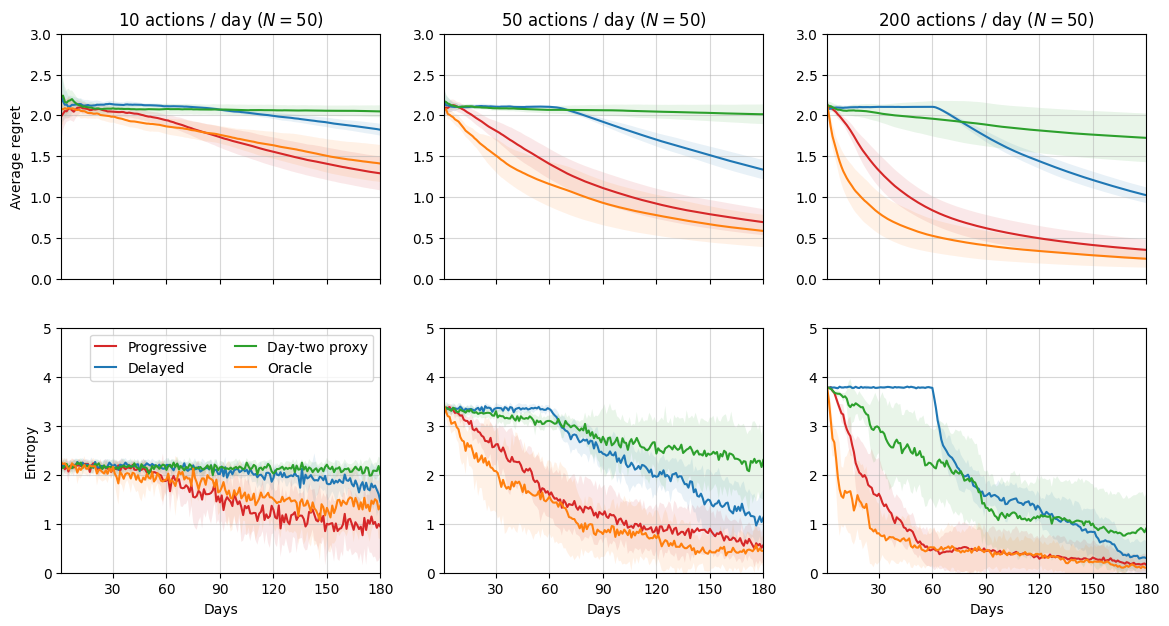

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharex=True, figsize=(14, 7))
xs = np.arange(1, horizon + 1)

color = {
    "Progressive": plt.cm.tab10(3),
    "Delayed": plt.cm.tab10(0),
    "Day-two proxy": plt.cm.tab10(2),
    "Oracle": plt.cm.tab10(1),
}
linestyle = {
    "Progressive": "-",
    "Delayed": "--",
    "Day-two proxy": "--",
    "Oracle": "--",
}

for col, n in enumerate(n_actions):
    axs[0, col].set_title(f"{n} actions / day ($N = {n_shows}$)")
    for name, regrets in reg[n].items():
        # Average regret.
        areg = np.cumsum(regrets, axis=1) / xs
        mean = np.mean(areg, axis=0)
        std = np.std(areg, axis=0)
        axs[0, col].plot(xs, mean, ls="-", color=color[name], label=name)
        axs[0, col].fill_between(
            xs, mean - std, mean + std, facecolor=color[name], alpha=0.1
        )
        axs[0, col].set_ylim(ymin=0, ymax=3)
        axs[0, col].grid(alpha=0.5)
    for name, entropies in ent[n].items():
        mean = np.mean(entropies, axis=0)
        std = np.std(entropies, axis=0)
        axs[1, col].plot(xs, mean, ls="-", color=color[name], label=name)
        axs[1, col].fill_between(
            xs, mean - std, mean + std, facecolor=color[name], alpha=0.1
        )
        axs[1, col].set_ylim(ymin=0, ymax=5)
        axs[1, col].set_xlabel("Days")
        axs[1, col].grid(alpha=0.5)

axs[1, 0].legend(frameon=True, ncol=2, handlelength=1.5)
axs[0, 2].set_xlim(xmin=1, xmax=180)
axs[0, 2].set_xticks(np.arange(30, 181, step=30))
axs[0, 0].set_ylabel("Average regret")
axs[1, 0].set_ylabel("Entropy");